# Executive Summary
Kiva is an international, nonprofit organization whose ultimate mission is to alleviate poverty through crowdfunded loans. Loans through Kiva are requested for a myriad of reasons including: to start or grow a business, to go to school, to access clean water or to simply repair a rickshaw to maintain a living. To date, Kiva has reached 2.6 million borrowers in 86 countries through 1.7 million lenders.   

To impact the greatest number of people, Kiva has established two working models: direct loans and partner loans. Direct loans are currently only available to U.S. residents and are made through Paypal. Partner loans, on the other hand, are adminstered through a Field Partner (local nonprofits or lending institutions) who will collect some interest. As mentioned by the Kiva Impact Team in the ongoing discussions, we are mostly concerned with the partner loans as they occur in rural and developing markets where interest in understanding borrower behavior is high. 

The partner loans follow a simple protocol:

1. The prospective borrower will meet with a Field Partner and apply for a loan;

2. The Field Partner will approve the loan and disberse funds right then;

3. The Field Partner will then upload loan details to Kiva's system; 

4. Kiva's pre-established network of volunteers will then edit and translate details as appropriate before going live on the website.

5. Once live, lenders will fund the loan in $25 increments until the amount is reached; 

6. When fundraising is complete, Kiva sends money to Field Partners;

7. Simultanesouly, borrowers (who received the money upfront before fundraising) are on a repayment schedule, often based on ability to pay. Payments are made to the Field Partner who sends the money back to the lenders through their Kiva accounts. 

8. At this point, lenders can choose to either fund another loan, donate the money to Kiva or withdraw theri money completely. 

According to Kiva's website, 100% of every dollar loaned on Kiva will go to backing loans. Kiva is otherwsie supported by optional donations, grants and/or sponsers. 

As funding in rural and developing markets can be unstable, Kiva is intent on learning more about borrower behavior. Understanding the psychology and circumstance around these microfinanced loans will better help Kiva set investment priorities, help inform prospective lenders, and better understand communities to hopefully then expand to other countries in need. 

Today, our goal is to use data from Kiva's active loans along with some external data sources to ultimately best estimate the welfare level of borrowers based on shared economic and demographic characteristics. The idea is to connect features of a loan or product to poverty mapping datasets in as granular manner as possible. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

In [3]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 999)

# Load Datasets Into SQL Database

In [4]:
def csv_into_sql(csv_file, sql_table, conn):
    try:
        conn.cursor().execute("SELECT 1 FROM %s LIMIT 1" % sql_table)
    except sqlite3.OperationalError:
        data = pd.read_csv(csv_file)
        data.columns = [col.lower().replace(' ', '_') for col in data.columns]
        data.to_sql(sql_table, conn, if_exists="replace")

In [5]:
#Create connection to sql database
conn = sqlite3.connect("kiva.sqlite")

In [6]:
#Load kiva_loans csv into SQL Database if it does not exist
csv_into_sql('kiva_loans.csv', 'kiva_loans', conn)

In [7]:
#Load kiva_mpi_region_locations csv into SQL Database if it does not exist
csv_into_sql('kiva_mpi_region_locations.csv', 'kiva_locations', conn)

In [8]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_themes_by_region.csv', 'loan_theme_region', conn)

In [9]:
#Load loan_themes_by_region csv into SQL Database if it does not exist
csv_into_sql('loan_theme_ids.csv', 'loan_theme', conn)

# Quick Loan Statistics in Kiva Crowdfunded Countries

In [10]:
#Create table with total loan amount, average loan amount and number of loans per country
loan_total = pd.read_sql_query(
    """
    SELECT SUM(loan_amount) AS total_loan_amount, COUNT(DISTINCT kiva_loans.id) AS num_loans, \
        AVG(loan_amount) AS average, kiva_loans.country AS country, kiva_locations.ISO
    FROM kiva_loans
    INNER JOIN kiva_locations ON kiva_loans.country = kiva_locations.country
    WHERE kiva_loans.country IS NOT NULL
    GROUP BY kiva_loans.country
    ORDER BY num_loans ASC
    """, 
    conn
)
loan_total

,total_loan_amount,num_loans,average,country,ISO
0,180000.0,1,15000.000000,Mauritania,MRT
1,476000.0,2,7000.000000,Afghanistan,AFG
2,380000.0,2,10000.000000,Bhutan,BTN
3,9250.0,4,2312.500000,Vanuatu,VUT
4,420875.0,8,4046.875000,Namibia,NAM
5,225875.0,75,3011.666667,Somalia,SOM
6,798175.0,125,912.200000,Belize,BLZ
7,1141575.0,134,2839.738806,China,CHN
8,1088100.0,160,755.625000,South Sudan,SSD
9,426100.0,180,2367.222222,Thailand,THA


In [11]:
#Transform each column into a readable format for mapping
loan_total['num_loans_string'] = loan_total['num_loans'].map(lambda x: "{:,}".format(x))

loan_total['avg_loans_string'] = loan_total['average'].map(lambda x: "${:,}".format(round(x, 2)))

loan_total['total_loans_string'] = loan_total['total_loan_amount'].map(lambda x: "${:,}".format(x))

In [12]:
loan_total['text'] = loan_total['country'] + '<br>' + \
                                    'Average Loan:' + ' ' + loan_total['avg_loans_string']

data = [ dict(
        type = 'choropleth',
        locations = loan_total['ISO'],
        z = loan_total['total_loan_amount'],
        text = loan_total['text'], 
        #colorscale = 'Blues',
        colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],

        reversescale = False,
        showlegend = True,
        colorbar = dict(
            #autotick = False,
            tick0= 0,
            tickprefix = '$',
            title = 'Total Funded <br>Amount (USD)'),
      ) ]

layout = dict(
    title = 'Total Loan Amounts in <br>Kiva Crowdfunded Countries',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

In [13]:
loan_total['text'] = loan_total['country'] + '<br>' + \
                                    'Average Loan:' + ' ' + loan_total['avg_loans_string']


data = [ dict(
        type = 'choropleth',
        locations = loan_total['ISO'],
        z = loan_total['num_loans'],
        text = loan_total['text'], 
        colorscale = 'Blues',
        #colorscale = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            #[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],

        reversescale = True,
        showlegend = True,
        colorbar = dict(
            #autotick = False,
            tick0= 0,
            #tickprefix = '$',
            title = 'Number of Loans <br>Funded'),
      ) ]

layout = dict(
    title = 'Number of Loans in <br>Kiva Crowdfunded Countries',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False)

# Kiva Loan Data Prep & Visualization

When a loan process is intiated, the loan is given a unique id number. This number was used to index the kiva_loans.csv dataset provided by the orgnizers and is therefore unique to each row. 

In [14]:
#Read in the data
kiva_loans = pd.read_sql_query("select * from kiva_loans;", conn)
kiva_loans.head()

,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01
1,1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01
2,2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01
4,4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01


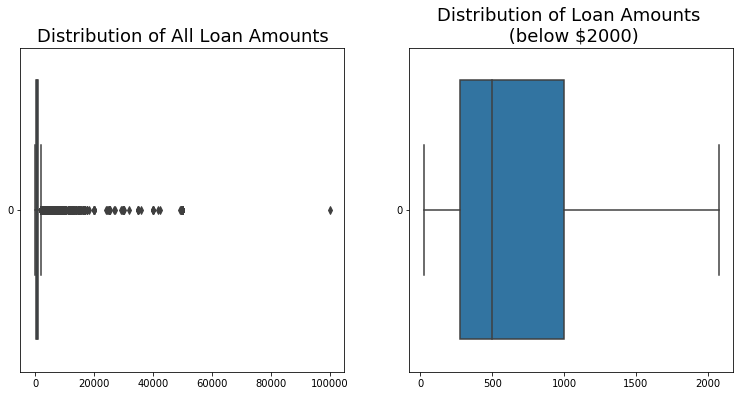

In [15]:
fig = plt.figure(figsize=(9,9))

axis1 = fig.add_axes([0,0,.5,.5])
axis1 = sns.boxplot(data = kiva_loans['loan_amount'], orient = 'h').set_title('Distribution of All Loan Amounts', size = 18);

axis2 = fig.add_axes([0.6,0,.5,.5])
axis2 = sns.boxplot(data = kiva_loans['loan_amount'], orient = 'h', showfliers=False).set_title('Distribution of Loan Amounts \n (below $2000)', size = 18);

Both of the graphs above depict the distribution of the 671,205 Kiva loans. The first graph gives us an overall picture while the second graph hones in on values less than \$2000. From the first boxplot, we can see that past loans have ranged from as low \$0 to as high as \$100,000. Unfortunately, we cannot glean much more information than that aside from the fact that most point seem to be less than \$2000. From the second plot, however, we have cut out the outliers in order to get a closer look of the distribution near the median. Accordingly we can see that most loans range from about \$250 to \$1000 with a median value aroud \$500.

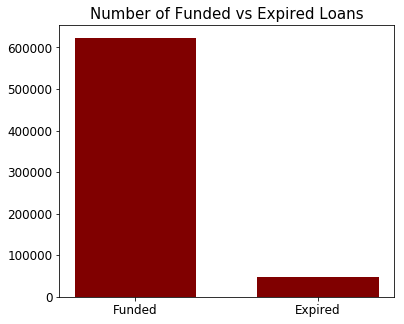

In [16]:
fig = plt.figure(figsize=(6,5))

funded = len(kiva_loans[kiva_loans['funded_amount'] >= kiva_loans['loan_amount']])
expired = len(kiva_loans[kiva_loans['funded_amount'] < kiva_loans['loan_amount']])

plt.bar(left = (0,0.3), height = (funded, expired), width = 0.2, color = 'maroon', tick_label = ('Funded', 'Expired'))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Number of Funded vs Expired Loans", fontsize = 15);

When the funded amount is less than loan amount, that means that the loan was posted on Kiva, but was not fully funded. This is called expiration. In such cases, all of the money is refunded to any lenders and Kiva doesn't back the loan at all. As we are attempting to describe borrower behavior, it may be more appropriate to focus only on funded loans. Fortunately, as pictured above, expired loans make up a very small proportion of the data (about 7% in fact). 

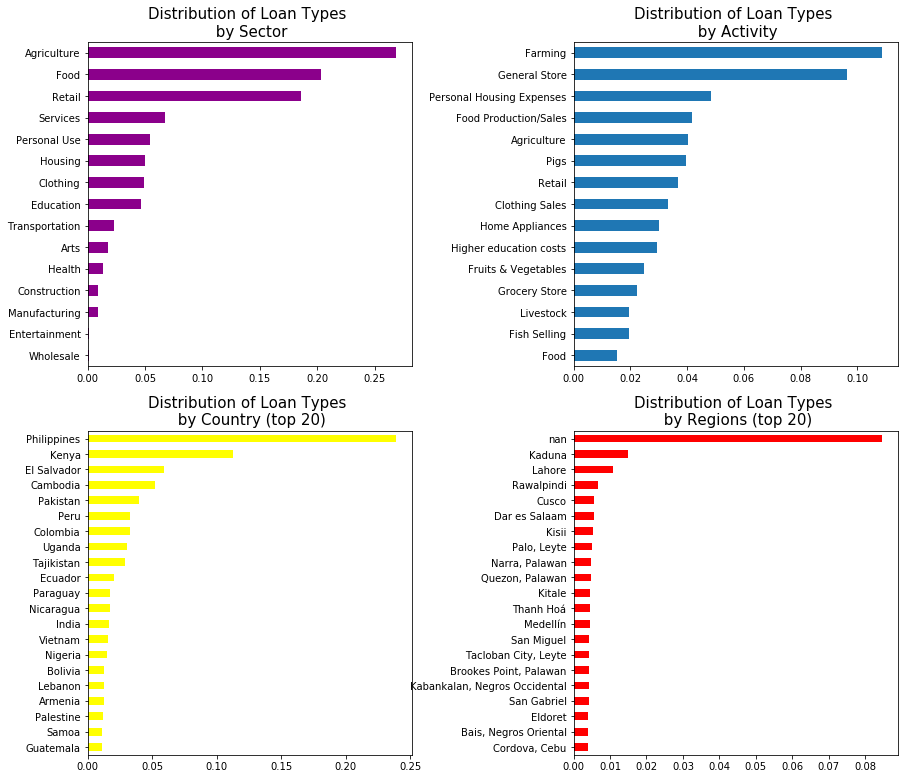

In [17]:
fig = plt.figure(figsize=(9,9))

#Distribution of Loans by Sector (Description of loan activity as shown to lenders)
axis1 = fig.add_axes([0,.6,.5,.5])
axis1 = kiva_loans['sector'].value_counts(normalize = True).sort_values(ascending = True).plot(kind = 'barh', color = 'darkmagenta')
axis1.set_title("Distribution of Loan Types \n by Sector", fontsize = 15);

#Distribution of Loans Activity Type 
axis2 = fig.add_axes([0.75,.6,.5,.5])
axis2 = kiva_loans['activity'].value_counts(normalize = True).sort_values(ascending = True)[-15:].plot(kind = 'barh')
axis2.set_title("Distribution of Loan Types \n by Activity", fontsize = 15);

#Distribution of Loans by Countries
axis3 = fig.add_axes([0,0,.5,.5])
axis3 = kiva_loans['country'].value_counts(normalize = True).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'yellow')
axis3.set_title("Distribution of Loan Types \n by Country (top 20)", fontsize = 15);

#Distribution of Loans by Regions
axis4 = fig.add_axes([0.75,0,.5,.5])
axis4 = kiva_loans['region'].value_counts(normalize = True,dropna = False).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'red')
axis4.set_title("Distribution of Loan Types \n by Regions (top 20)", fontsize = 15);

The above four plots give a quick visual of Kiva loans broken down by sector, activity, countries and regions. 
Sector descriptions are those lenders see when deciding whether to help fund a loan. It gives a broad description of what the money will be used for. As we can see, the three most popular loans include: Agriculture, Food and Retail--making up almost 65% of all loans. 

The plot in the top right breaks loans down by activity, which is simply a more granular description of what the loan was used for. While the chart only shows the top 15 activities, there are actually about 163 different categories. Among these, Farming and General Store were overwhelmingly present, representing about 20% of the data while all other categories made up 4% or below.

The plot in the bottom left breaks loans down by countries. Similar to what we saw on the map, the Philippines certainly dominates with over 20% of all loans. 

The bottom right plot, breaks loans down by region. Of all four, this is the most interesting as it seems to be missing a majority of its data at about 84%. As Kiva is particularly interested in a more granular insights, it makes sense that they are missing most of the data for this category. It will be our job to infer these regions (if possible) moving forward. 

In [18]:
#Create columns with singular male, female or both label
gender_list = []
for row in kiva_loans['borrower_genders']:
    if row == None:
        gender_list.append('unknown')
    elif (' male' in row) & (' female' in row): 
        gender_list.append('both')
    elif 'female' in row:
        gender_list.append('female')
    elif 'male' in row:
        gender_list.append('male')   

In [19]:
kiva_loans['gender'] = gender_list

In [20]:
#Create column for borrowers
borrower_num = []
for row in kiva_loans['borrower_genders']:
    if row == None:
        borrower_num.append('unknown')
    else:
        borrower_num.append(len(row.split(' ')))

In [21]:
kiva_loans['number_of_borrowers'] = borrower_num

In [22]:
kiva_loans.head()

,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers
0,0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01,female,1
1,1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01,female,2
2,2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1
3,3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01,female,1
4,4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01,female,1


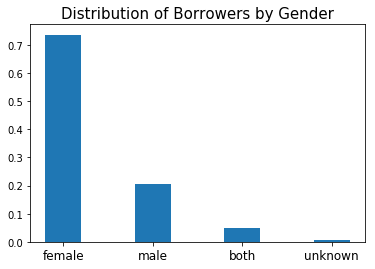

In [23]:
plt.bar(left = np.arange(len(kiva_loans['gender'].value_counts(normalize = True))), \
        height = kiva_loans['gender'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['gender'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Borrowers by Gender", fontsize = 15);

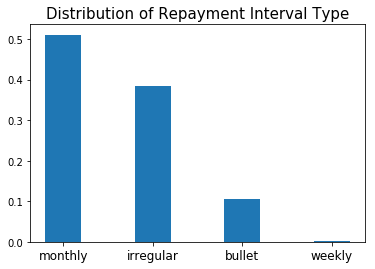

In [24]:
#Plot repayment interval
plt.bar(left = np.arange(len(kiva_loans['repayment_interval'].value_counts(normalize = True))), \
        height = kiva_loans['repayment_interval'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans['repayment_interval'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Distribution of Repayment Interval Type", fontsize = 15);

In [25]:
#Label the quarter the loan was asked for
quarter = []
for row in kiva_loans['date']: 
    month = int(row.split('-')[1])
    
    if (month >= 1) & (month <= 3):
        quarter.append('1')
    
    elif (month >= 4) & (month <= 6):
        quarter.append('2')
        
    elif (month >= 7) & (month <= 9):
        quarter.append('3')
    
    elif (month >= 10) & (month <= 12):
        quarter.append('4')
        

In [26]:
kiva_loans['quarter_loan_posted'] = quarter

In [27]:
kiva_loans.head()

,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers,quarter_loan_posted
0,0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,None,female,irregular,2014-01-01,female,1,1
1,1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used in their business.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,None,"female, female",irregular,2014-01-01,female,2,1
2,2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another one to rent out as a source of income,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,female,1,1
3,3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variety of new embroidery materials.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,None,female,irregular,2014-01-01,female,1,1
4,4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,None,female,monthly,2014-01-01,female,1,1


In [97]:
kiva_loans[(kiva_loans['date'].str.contains('2015')) & (kiva_loans['quarter_loan_posted']=='1')]

,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,gender,number_of_borrowers,quarter_loan_posted
174234,174234,823048,450.0,450.0,Butcher Shop,Food,to purchase additional pigs for her business.,PH,Philippines,"Kabankalan, Negros Occidental",PHP,145.0,2015-01-01 02:38:53+00:00,2014-12-12 08:00:00+00:00,2015-01-01 16:20:50+00:00,8.0,14,None,female,irregular,2015-01-01,female,1,1
174235,174235,823138,200.0,200.0,Food Production/Sales,Food,"to buy ingredients such as soy sauce, meat, noodles, cooking oil, seasoning and salt for her food vending business.",PH,Philippines,"Baybay, Leyte",PHP,125.0,2015-01-01 15:57:25+00:00,2014-12-02 08:00:00+00:00,2015-01-05 00:21:31+00:00,10.0,5,None,female,irregular,2015-01-01,female,1,1
174236,174236,823051,175.0,175.0,Fruits & Vegetables,Food,to purchase additional boxes of bananas to sell.,PH,Philippines,"Kabankalan, Negros Occidental",PHP,145.0,2015-01-01 02:49:11+00:00,2014-12-10 08:00:00+00:00,2015-01-01 06:12:18+00:00,8.0,4,None,female,irregular,2015-01-01,female,1,1
174237,174237,823143,675.0,675.0,Fishing,Food,"to buy new fishing nets, lead weights, floaters and fuel",PH,Philippines,"Carles, Iloilo",PHP,125.0,2015-01-01 16:20:43+00:00,2014-12-03 08:00:00+00:00,2015-01-05 19:21:50+00:00,20.0,26,"user_favorite, #Biz Durable Asset, #Parent",female,irregular,2015-01-01,female,1,1
174238,174238,823154,1450.0,1450.0,Agriculture,Agriculture,to purchase a solar light and gain access to cost efficient hybrid seeds and fertilizer for maize cultivation.\t\t\t\t\t\t\t,KE,Kenya,Webuye,KES,202.0,2015-01-01 19:59:25+00:00,2015-02-01 08:00:00+00:00,2015-01-04 22:16:31+00:00,11.0,45,None,"female, female, female, female, female, male, female, female, female, female, female, female, female, female, male",bullet,2015-01-01,both,15,1
174239,174239,823117,250.0,250.0,Liquor Store / Off-License,Food,to buy additional containers of coconut wine to sell.,PH,Philippines,"Tacloban City, Leyte",PHP,145.0,2015-01-01 14:14:57+00:00,2014-12-12 08:00:00+00:00,2015-01-03 01:31:28+00:00,8.0,7,None,female,irregular,2015-01-01,female,1,1
174240,174240,823100,450.0,450.0,Cloth & Dressmaking Supplies,Retail,to purchase good-quality cloth of different colors,PK,Pakistan,Jaranwala,PKR,245.0,2015-01-01 12:09:06+00:00,2014-12-10 08:00:00+00:00,2015-01-30 03:22:37+00:00,14.0,16,"#Fabrics, #Woman Owned Biz",female,monthly,2015-01-01,female,1,1
174241,174241,823132,900.0,900.0,Pigs,Agriculture,"to buy more hogs to resell, more chorizo (pork sausage), and feed to keep her hogs healthy",PH,Philippines,"Baybay, Leyte",PHP,125.0,2015-01-01 15:36:55+00:00,2014-12-02 08:00:00+00:00,2015-01-27 01:34:00+00:00,12.0,19,"#Woman Owned Biz, #Parent",female,irregular,2015-01-01,female,1,1
174242,174242,823137,225.0,225.0,Food Production/Sales,Food,to buy an ice crusher and popcorn machine so she can sell more snacks,PH,Philippines,"Baybay, Leyte",PHP,125.0,2015-01-01 15:52:50+00:00,2014-12-02 08:00:00+00:00,2015-01-03 22:37:06+00:00,12.0,7,"#Biz Durable Asset, #Woman Owned Biz, #Parent",female,irregular,2015-01-01,female,1,1
174243,174243,823050,250.0,250.0,Food Production/Sales,Food,to buy ingredients for her food production business,PH,Philippines,"Kabankalan, Negros Occidental",PHP,145.0,2015-01-01 02:44:45+00:00,2014-12-10 08:00:00+00:00,2015-01-01 04:29:02+00:00,5.0,7,None,female,irregular,2015-01-01,female,1,1


In [62]:
num_loans_time ={}

for year in ['2014', '2015','2016', '2017']:
    for quarter in range(1, 5):
        num = len(kiva_loans[(kiva_loans['date'].str.contains(year)) & \
                             (kiva_loans['quarter_loan_posted']==str(quarter))])
        
        num_loans_time["%s Q%d" % (year, quarter)] = num

In [68]:
#Remove 2017 Q4 since it does not exist in our dataset
del num_loans_time['2017 Q4']

In [85]:
#For graphing purposes, we will also remove 2017 Q3 since there is only a month's worth of data
del num_loans_time['2017 Q3']

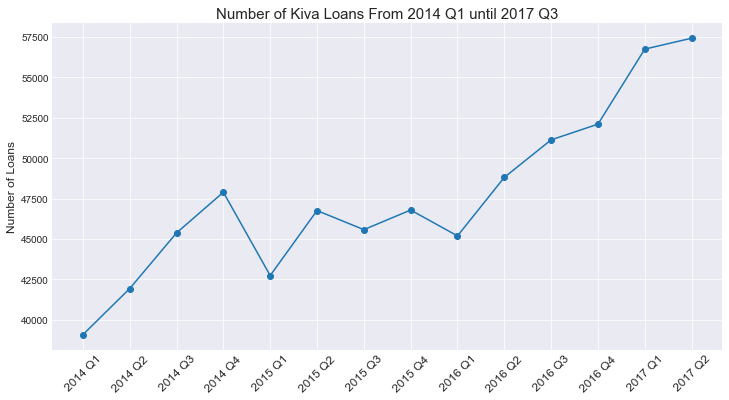

In [86]:
sns.set_style('darkgrid')
plt.figure(figsize = (12,6))
plt.plot(np.arange(len(num_loans_time)), list(num_loans_time.values()), marker='o')
plt.xticks(np.arange(len(num_loans_time)), list(num_loans_time.keys()), fontsize = 12, rotation = 45)
plt.ylabel("Number of Loans", fontsize = 12)
plt.title("Number of Kiva Loans From 2014 Q1 until 2017 Q3", fontsize = 15);

In [87]:
country_loans_time ={}

for year in ['2014', '2015','2016', '2017']:
    for quarter in range(1, 5):
        countries = kiva_loans[(kiva_loans['date'].str.contains(year)) & \
                             (kiva_loans['quarter_loan_posted']==str(quarter))]['country'].nunique()
        
        country_loans_time["%s Q%d" % (year, quarter)] = countries

In [89]:
#Similar to above, we will remove 2017 Q4 since it does not exist in our dataset
del country_loans_time['2017 Q4']

In [91]:
#Also similar to above, we will remove 2017 Q3 since there is only a month's worth of data
del country_loans_time['2017 Q3']

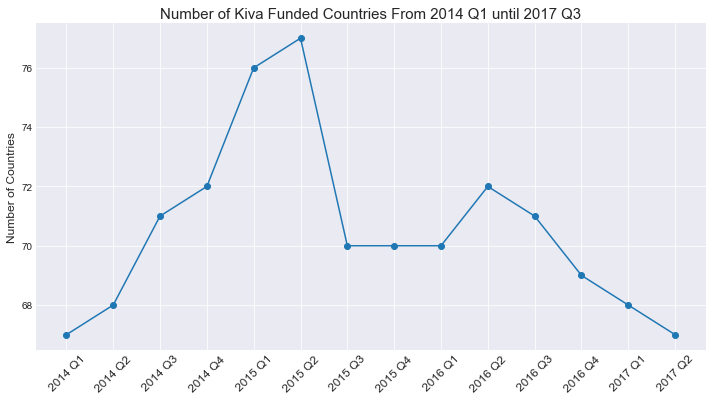

In [95]:
plt.figure(figsize = (12,6))
plt.plot(np.arange(len(country_loans_time)), list(country_loans_time.values()), marker='o')
plt.xticks(np.arange(len(country_loans_time)), list(country_loans_time.keys()), fontsize = 12, rotation = 45)
plt.ylabel("Number of Countries", fontsize = 12)
plt.title("Number of Kiva Funded Countries From 2014 Q1 until 2017 Q3", fontsize = 15);

In [163]:
#Calculate how many loans were fulfilled
#Calculate how many loans were paid back
#Aggregate payment type
#Calculate post time
#Find conversion rate
#If done over a span of years, find inflation rate
#Label quarter loan was asked for/fulfilled

In [88]:
#Datasets to bring in (prob from World Bank): 
#poverty index
#education levels
#male/female populatino ratios
#economic situation

In [268]:
kiva_loc = pd.read_csv("kiva_mpi_region_locations.csv")
kiva_loc.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [233]:
#Unique by id for loan
loan_theme_id = pd.read_csv("loan_theme_ids.csv")
loan_theme_id.head()

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0
